<a href="https://colab.research.google.com/github/Winkielek/gflownet/blob/master/notebooks/mols_patterns_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# Clone gflownet lib
!rm -rf gflownet
!git clone https://github.com/Winkielek/gflownet.git

# Freeze torch version
!pip install torch==2.1.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html

# Install torch geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-geometric scipy==1.8 deepchem

# Install gflownet lib
!pip install -e ./gflownet

Cloning into 'gflownet'...
remote: Enumerating objects: 1435, done.
remote: Counting objects: 100% (559/559), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 1435 (delta 419), reused 368 (delta 343), pack-reused 876
Receiving objects: 100% (1435/1435), 33.74 MiB | 19.33 MiB/s, done.
Resolving deltas: 100% (796/796), done.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    F

In [ ]:
!pip install multiset

In [52]:
import os
import shutil
import socket
from typing import Callable, Dict, List, Tuple, Union
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch_geometric.data as gd
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor
from torch.utils.data import Dataset

from gflownet.config import Config
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext, Graph
from gflownet.models import bengio2021flow
from gflownet.online_trainer import StandardOnlineTrainer
from gflownet.trainer import FlatRewards, GFNTask, RewardScalar
from gflownet.utils.conditioning import TemperatureConditional
from gflownet.tasks.seh_frag import SEHFragTrainer

import matplotlib.pyplot as plt
import networkx as nx
import deepchem as dc

from multiset import *
from collections import defaultdict
from nltk import ngrams

# Load model

In [2]:
if __name__ == "__main__":

    hps = {
        "log_dir": "./logs/debug_run_seh_frag_pb",
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "overwrite_existing_exp": True,
        "num_training_steps": 500,
        "num_workers": 2,
        "opt": {
            "lr_decay": 20000,
        },
        "algo": {"sampling_tau": 0.99, "offline_ratio": 0.0},
        "cond": {
            "temperature": {
                "sample_dist": "uniform",
                "dist_params": [0, 64.0],
            }
        },
    }
    if os.path.exists(hps["log_dir"]):
        if hps["overwrite_existing_exp"]:
            shutil.rmtree(hps["log_dir"])
        else:
            raise ValueError(f"Log dir {hps['log_dir']} already exists. Set overwrite_existing_exp=True to delete it.")
    os.makedirs(hps["log_dir"])

    trial = SEHFragTrainer(hps)
    # trial.print_every = 100
    # trial.run()



Hyperparameters:

log_dir: ./logs/debug_run_seh_frag_pb
device: cuda
seed: 0
validate_every: 1000
checkpoint_every: null
print_every: 100
start_at_step: 0
num_final_gen_steps: null
num_training_steps: 500
num_workers: 2
hostname: 98aabca93dec
pickle_mp_messages: false
git_hash: cdc42ab
overwrite_existing_exp: true
algo:
  method: TB
  global_batch_size: 64
  max_len: 128
  max_nodes: 9
  max_edges: 128
  illegal_action_logreward: -75.0
  offline_ratio: 0.0
  valid_offline_ratio: 0.0
  train_random_action_prob: 0.0
  valid_random_action_prob: 0.0
  valid_sample_cond_info: true
  sampling_tau: 0.99
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.001
    Z_lr_decay: 50000.0
    cum_subtb: true
  moql:
    gamma: 1.0
    num_omega_samples: 32
    num_objectives: 2
    la

In [3]:
PATH = "./model"

In [4]:
model = trial.model
model.load_state_dict(torch.load(PATH))
model = model.to("cuda")

# Sample molecules

In [5]:
n = 10000
batch_size = 100
num_gen = 0

traj = []
rew = []

while num_gen < n:

    pred = trial.algo.graph_sampler.sample_from_model(
        model,
        batch_size,
        trial.task.sample_conditional_information(batch_size,None)["encoding"].to("cuda"),
        "cuda"
    )

    # Store trajectories
    for p in pred:
        traj.append(p["traj"])
    # Store rewards
    mols = [trial.ctx.graph_to_mol(p["result"])for p in pred]
    rewards = trial.task.compute_flat_rewards(mols)
    rewards = rewards[0].numpy().reshape(-1).tolist()
    rew += rewards
    num_gen += batch_size

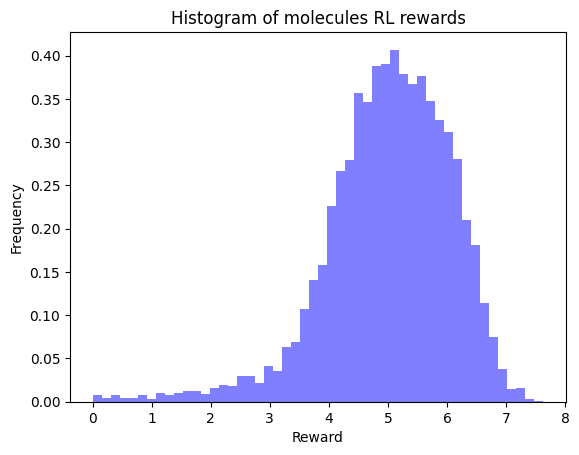

In [6]:
# Create a histogram
plt.hist([x*8 for x in rew], bins=50, density=True, alpha=0.5, color='blue')

# Add labels and title
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Histogram of molecules RL rewards')

# Show the plot
plt.show()

# Analysis

## Trajectory info

In [7]:
# How does a step of trajectory look like?
traj_id = 10
state = 4
print(traj[traj_id][state])
print(f"Current graph: {traj[traj_id][state][0]}")
cur_action = traj[traj_id][state][1]
print(f"Current action: {cur_action}")
print(f"Action source: {cur_action.source}")
print(f"Action target: {cur_action.target}")
print(f"Action value: {cur_action.value}")


(<[0, 1, 2], [(0, 1), (1, 2)], [7, 7, 65]>, <GraphActionType.AddNode, 0, 7>)
Current graph: <[0, 1, 2], [(0, 1), (1, 2)], [7, 7, 65]>
Current action: <GraphActionType.AddNode, 0, 7>
Action source: 0
Action target: None
Action value: 7


## Chemical features per reward bin

In [59]:
mols = []
rewards_list = []
for traj_id, trajectory in enumerate(traj):
    mol = trial.ctx.graph_to_mol(trajectory[-1][0])
    final_reward = float(trial.task.compute_flat_rewards([mol])[0][0][0])

    rewards_list.append(final_reward)
    mols.append(mol)

In [65]:
dc.feat.RDKitDescriptors

deepchem.feat.molecule_featurizers.rdkit_descriptors.RDKitDescriptors

In [69]:
feat = dc.feat.RDKitDescriptors()

arr = feat.featurize(mols)

df = pd.DataFrame(arr, columns=feat.descriptors)

In [76]:
df_to_analyse = df[["Kappa3", "BertzCT", "SMR_VSA7"]].copy()
df_to_analyse["reward_bin"] = pd.cut(rewards_list, [0, 0.33, 0.67, 1], labels = ["low_reward", "mid_reward", "high_reward"])

In [79]:
df_to_analyse.groupby("reward_bin").median()

,Kappa3,BertzCT,SMR_VSA7
reward_bin,,,
low_reward,7.573186,1475.582937,64.656233
mid_reward,7.609276,1462.220935,60.928629
high_reward,7.618692,1466.254000,60.935917


In [80]:
df_to_analyse.groupby("reward_bin").mean()

,Kappa3,BertzCT,SMR_VSA7
reward_bin,,,
low_reward,7.587050,1532.673223,66.203946
mid_reward,7.599381,1513.676904,63.460288
high_reward,7.591284,1513.278871,62.805895


## Particles used among different reward bins




In [8]:
mol_details = {}
rewards_list = []
for traj_id, trajectory in enumerate(traj):
    final_state = trajectory[-1][0]

    mol_smiles = {}
    for i in final_state.nodes:
        mol_smile = trial.ctx.frags_smi[final_state.nodes[i]["v"]]
        mol_smiles[i] = mol_smile

    final_reward = trial.task.compute_flat_rewards([trial.ctx.graph_to_mol(final_state)])


    mol_details[traj_id] = {
        "mols_included": mol_smiles,
        "final_reward": float(final_reward[0][0][0])
    }

In [9]:
dfs_to_concat = []

for mol_id, mol_info in mol_details.items():
    reward = mol_info["final_reward"]
    mols_included = mol_info["mols_included"]

    dfs_to_concat.append(pd.DataFrame({
        "final_molecule_id": [mol_id for i in range(len(mols_included))],
        "mol_smile":mols_included.values(),
        "mol_position": mols_included.keys(),
        "final_reward": [reward for i in range(len(mols_included))],
        "final_molecule_length": [len(mols_included.keys()) for i in range(len(mols_included))]
    }))

mol_df = pd.concat(dfs_to_concat)

In [12]:
mol_df["reward_bin"] = pd.cut(mol_df['final_reward'], [0, 0.33, 0.67, 1], labels = ["low_reward", "mid_reward", "high_reward"])

In [13]:
mol_df

,final_molecule_id,mol_smile,mol_position,final_reward,final_molecule_length,reward_bin
0,0,c1cn[nH]c1,0,0.625934,9,mid_reward
1,0,C1CNCCN1,1,0.625934,9,mid_reward
2,0,CO,2,0.625934,9,mid_reward
3,0,C1CCOCC1,3,0.625934,9,mid_reward
4,0,c1cn[nH]c1,4,0.625934,9,mid_reward
...,...,...,...,...,...,...
4,9999,O=c1cc[nH]c(=O)[nH]1,4,0.766707,9,high_reward
5,9999,C1CCCCC1,5,0.766707,9,high_reward
6,9999,C1CCNCC1,6,0.766707,9,high_reward
7,9999,c1ccccc1,7,0.766707,9,high_reward


In [16]:
mols_freq = mol_df.groupby(["reward_bin", "mol_smile"], observed = True).size().reset_index(name = "count").sort_values(["reward_bin","count"], ascending = False).sort_values("count", ascending = False)

In [18]:
mols_freq["sum_per_reward_bin"] = mols_freq.groupby("reward_bin")["count"].transform("sum")
mols_freq["normalized_freq"] = mols_freq["count"] / mols_freq["sum_per_reward_bin"]

In [19]:
import plotly.express as px

fig = px.bar(mols_freq, x="mol_smile", y="normalized_freq", color="reward_bin", barmode='group')

fig.show()

## Particles frequency table

In [45]:
mol_df.groupby(["reward_bin", "mol_smile"], observed = True).size().reset_index(name = "count").sort_values(["reward_bin","count"], ascending = False).sort_values("count", ascending = False).groupby("reward_bin").head(5).sort_values(["reward_bin", "count"], ascending = [False, True]).reset_index(drop=True)

,reward_bin,mol_smile,count
0,high_reward,C1CCNC1,2455
1,high_reward,C1CCOCC1,2893
2,high_reward,c1ccccc1,3350
3,high_reward,CNC=O,3445
4,high_reward,C1CCCCC1,7130
5,mid_reward,C1CCNC1,3018
6,mid_reward,c1ccccc1,3363
7,mid_reward,CNC=O,3634
8,mid_reward,C1CCOCC1,4503
9,mid_reward,C1CCCCC1,12500


In [21]:
mols_details = mol_df.groupby(["reward_bin", "mol_smile"], observed = True).agg(
    avg_mol_position=("mol_position", "mean"),
    median_mol_position=("mol_position", "median"),
    count = ("mol_position", "count")
    ).reset_index()

In [23]:
mols_details.sort_values("median_mol_position")

,reward_bin,mol_smile,avg_mol_position,median_mol_position,count
8,low_reward,C1CCNC1,2.728814,2.0,177
79,mid_reward,C1CCCCC1,2.538560,2.0,12500
174,high_reward,CNC=O,2.614514,2.0,3445
7,low_reward,C1CCCCC1,2.421053,2.0,361
151,high_reward,C1CCCCC1,2.624965,2.0,7130
...,...,...,...,...,...
122,mid_reward,O=[NH+][O-],7.335329,8.0,167
121,mid_reward,O=S=O,7.400000,8.0,80
120,mid_reward,O=P[O-],7.159204,8.0,201
145,high_reward,C,7.416667,8.0,36


## Particles as sequences

In [30]:
dfs_to_concat = []

N_GRAM_SIZE = 3
for id in mol_df["final_molecule_id"].unique():
    reward_bin = mol_df.loc[mol_df["final_molecule_id"] == id].reward_bin.values[0]
    mol_smiles = mol_df.loc[mol_df["final_molecule_id"] == id].mol_smile.values
    n_grams = ngrams(mol_smiles, N_GRAM_SIZE)

    for seq_position, grams in enumerate(n_grams):
        dfs_to_concat.append(pd.DataFrame({
            "mol_sequence": [Multiset(grams)],
            "sequence_start_position": [seq_position],
            "reward_bin": [reward_bin]

        }))

result_df = pd.concat(dfs_to_concat)

In [31]:
result_df["mol_sequence"] = result_df["mol_sequence"].astype(str)


n_grams_results = result_df.groupby(["reward_bin", "mol_sequence"]).agg(
    count=("sequence_start_position", "count"),
    avg_start_position=("sequence_start_position", "mean"),
    median_start_position=("sequence_start_position", "median")
).reset_index()

In [32]:
n_grams_results.sort_values("count", ascending = False).groupby("reward_bin").head(5).sort_values("reward_bin")

,reward_bin,mol_sequence,count,avg_start_position,median_start_position
551,high_reward,"{C1CCCCC1, C1CCCCC1, CNC=O}",338,1.144970,1.0
537,high_reward,"{C1CCCCC1, C1CCCCC1, C1CCCCC1}",298,1.194631,1.0
541,high_reward,"{C1CCCCC1, C1CCCCC1, C1CCOCC1}",231,1.523810,1.0
571,high_reward,"{C1CCCCC1, C1CCCCC1, c1ccccc1}",231,2.367965,2.0
538,high_reward,"{C1CCCCC1, C1CCCCC1, C1CCNC1}",180,1.822222,1.0
8595,low_reward,"{C1CCCCC1, C1CCCCC1, C1CCCCC1}",17,1.352941,1.0
8599,low_reward,"{C1CCCCC1, C1CCCCC1, C1CCOCC1}",14,1.285714,1.0
9103,low_reward,"{C1CCOCC1, C1CCOCC1, C1CCCCC1}",11,0.818182,0.0
8611,low_reward,"{C1CCCCC1, C1CCCCC1, c1ccccc1}",11,0.818182,0.0
8596,low_reward,"{C1CCCCC1, C1CCCCC1, C1CCNC1}",11,0.909091,1.0


In [33]:
n_grams_pos = n_grams_results.sort_values("count", ascending = False).groupby(["reward_bin", "median_start_position"]).head(1).sort_values(["reward_bin", "median_start_position"])

n_grams_pos.loc[n_grams_pos["median_start_position"] < 2]

,reward_bin,mol_sequence,count,avg_start_position,median_start_position
2842,high_reward,"{C1CCOCC1, CNC=O, C1CNCCN1}",12,1.583333,0.0
4473,high_reward,"{CNC=O, CNC=O, C1=CNC=CC1}",22,1.227273,0.5
551,high_reward,"{C1CCCCC1, C1CCCCC1, CNC=O}",338,1.144970,1.0
2838,high_reward,"{C1CCOCC1, CNC=O, C1CCCCC1}",42,1.880952,1.5
9103,low_reward,"{C1CCOCC1, C1CCOCC1, C1CCCCC1}",11,0.818182,0.0
8633,low_reward,"{C1CCCCC1, C1CCNC1, c1cn[nH]c1}",4,0.500000,0.5
8595,low_reward,"{C1CCCCC1, C1CCCCC1, C1CCCCC1}",17,1.352941,1.0
8616,low_reward,"{C1CCCCC1, C1CCCCC1, c1ncc2nc[nH]c2n1}",4,1.500000,1.5
19041,mid_reward,"{O=c1[nH]cnc2c1NCCN2, C1CCCCC1, C1CCCCC1}",25,1.240000,0.0
21783,mid_reward,"{c1ccsc1, CNC=O, C1CCCCC1}",10,1.200000,0.5


In [34]:
n_grams_pos = n_grams_results.sort_values("count", ascending = False).groupby(["reward_bin"]).head(3).sort_values(["reward_bin"])
n_grams_pos

,reward_bin,mol_sequence,count,avg_start_position,median_start_position
551,high_reward,"{C1CCCCC1, C1CCCCC1, CNC=O}",338,1.144970,1.0
537,high_reward,"{C1CCCCC1, C1CCCCC1, C1CCCCC1}",298,1.194631,1.0
541,high_reward,"{C1CCCCC1, C1CCCCC1, C1CCOCC1}",231,1.523810,1.0
8595,low_reward,"{C1CCCCC1, C1CCCCC1, C1CCCCC1}",17,1.352941,1.0
8599,low_reward,"{C1CCCCC1, C1CCCCC1, C1CCOCC1}",14,1.285714,1.0
9103,low_reward,"{C1CCOCC1, C1CCOCC1, C1CCCCC1}",11,0.818182,0.0
10997,mid_reward,"{C1CCCCC1, C1CCCCC1, C1CCCCC1}",839,1.127533,1.0
11001,mid_reward,"{C1CCCCC1, C1CCCCC1, C1CCOCC1}",586,1.498294,1.0
11017,mid_reward,"{C1CCCCC1, C1CCCCC1, CNC=O}",538,1.345725,1.0


In [35]:
to_plot = n_grams_results[(n_grams_results["median_start_position"] <= 1)].sort_values("count", ascending = False).groupby(["reward_bin"]).head(8)

In [36]:
to_plot["sum_per_reward_bin"] = to_plot.groupby("reward_bin")["count"].transform("sum")
to_plot["normalized_freq"] = to_plot["count"] / to_plot["sum_per_reward_bin"]

In [37]:
to_plot["reward_bin"] = to_plot["reward_bin"].replace({
    "low_reward": "Low",
    "mid_reward": "Medium",
    "high_reward": "High"
})
to_plot["reward_bin"] = pd.Categorical(to_plot["reward_bin"], ["Low", "Medium", "High"])

In [81]:
import plotly.express as px

to_plot = to_plot.sort_values(["reward_bin", "count"], ascending= [False, False])
to_plot["mol_seq_id"] = to_plot.groupby(["mol_sequence"]).grouper.group_info[0].astype(str)
to_plot["mol_seq_id"] = "seq_" + to_plot["mol_seq_id"]


fig = px.bar(to_plot, x="mol_seq_id", y="normalized_freq", color="reward_bin", barmode='group')

fig.update_layout(
    template="plotly_white",
    xaxis_title = "Sequence ID",
    yaxis_title = "Normalized frequency",
    title = "Frequency of particle sequences in the beginning of building the molecule",
    legend_title_text='Reward bin'


)

fig.show()

In [88]:
to_plot

,reward_bin,mol_sequence,count,avg_start_position,median_start_position,sum_per_reward_bin,normalized_freq,mol_seq_id,id
551,High,"{C1CCCCC1, C1CCCCC1, CNC=O}",338,1.144970,1.0,1667,0.202759,seq_5,5
537,High,"{C1CCCCC1, C1CCCCC1, C1CCCCC1}",298,1.194631,1.0,1667,0.178764,seq_0,0
541,High,"{C1CCCCC1, C1CCCCC1, C1CCOCC1}",231,1.523810,1.0,1667,0.138572,seq_3,3
538,High,"{C1CCCCC1, C1CCCCC1, C1CCNC1}",180,1.822222,1.0,1667,0.107978,seq_1,1
4255,High,"{CNC=O, C1CCCCC1, C1CCCCC1}",163,1.233129,1.0,1667,0.097780,seq_11,11
4474,High,"{CNC=O, CNC=O, C1CCCCC1}",158,1.462025,1.0,1667,0.094781,seq_12,12
539,High,"{C1CCCCC1, C1CCCCC1, C1CCNCC1}",157,1.566879,1.0,1667,0.094181,seq_2,2
542,High,"{C1CCCCC1, C1CCCCC1, C1CNCCN1}",142,1.485915,1.0,1667,0.085183,seq_4,4
10997,Medium,"{C1CCCCC1, C1CCCCC1, C1CCCCC1}",839,1.127533,1.0,3526,0.237947,seq_0,0
11001,Medium,"{C1CCCCC1, C1CCCCC1, C1CCOCC1}",586,1.498294,1.0,3526,0.166194,seq_3,3
